<a href="https://colab.research.google.com/github/ahoucbvtw/Stock-Predict/blob/main/Stock-Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas==0.25.1

In [ ]:
import pandas as pd
print(pd.__version__)

0.25.1


In [ ]:
# 沒什麼用到可以不用執行
!pip install -r requirements.txt

In [ ]:
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

Selecting previously unselected package libta-lib0.
(Reading database ... 144618 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for ta-lib: filename=TA_Lib-0.4.19-cp36-cp36m-linux_x86_64.whl size=1437802 sha256=95d1abd9399260eeab401327aa335ab5eed431bdf3d09f92b7839d88fec78053
  Stored in directory: /root/.cache/pip/wheels/a3/f6/12/3d1ccd06caadd8fa47e016991dd0d27f1163bb260f1854e2ff
Successfully built ta-lib


In [ ]:
import numpy as np
# import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as datetime
import mpl_finance as mpf
import fbprophet
stoke_code = "2412"

In [ ]:
# Quandl for financial analysis, pandas and numpy for data manipulation
# fbprophet for additive models, #pytrends for Google trend data
# import pandas as pd
# import numpy as np
# import fbprophet

# matplotlib pyplot for plotting
# import matplotlib.pyplot as plt

import matplotlib

# Class for analyzing and (attempting) to predict future prices
# Contains a number of visualizations and analysis methods
class Stocker():
    
    # Initialization requires a ticker symbol
    def __init__(self, price):
        self.symbol = 'the stock'
        s = price
        stock = pd.DataFrame({'Date':s.index, 'y':s, 'ds':s.index, 'close':s,'open':s}, index=None)

        if ('Adj. Close' not in stock.columns):
            stock['Adj. Close'] = stock['close']
            stock['Adj. Open'] = stock['open']
        
        stock['y'] = stock['Adj. Close']
        stock['Daily Change'] = stock['Adj. Close'] - stock['Adj. Open']
        
        # Data assigned as class attribute
        self.stock = stock.copy()
        
        # Minimum and maximum date in range
        self.min_date = min(stock['ds'])
        self.max_date = max(stock['ds'])
        
        # Find max and min prices and dates on which they occurred
        self.max_price = np.max(self.stock['y'])
        self.min_price = np.min(self.stock['y'])
        
        self.min_price_date = self.stock[self.stock['y'] == self.min_price]['ds']
        self.min_price_date = self.min_price_date[self.min_price_date.index[0]]
        self.max_price_date = self.stock[self.stock['y'] == self.max_price]['ds']
        self.max_price_date = self.max_price_date[self.max_price_date.index[0]]
        
        # The starting price (starting with the opening price)
        self.starting_price = float(self.stock.ix[0, 'Adj. Open'])
        
        # The most recent price
        self.most_recent_price = float(self.stock.ix[len(self.stock) - 1, 'y'])

        # Whether or not to round dates
        self.round_dates = True
        
        # Number of years of data to train on
        self.training_years = 3

        # Prophet parameters
        # Default prior from library
        self.changepoint_prior_scale = 0.05 
        self.weekly_seasonality = False
        self.daily_seasonality = False
        self.monthly_seasonality = True
        self.yearly_seasonality = True
        self.changepoints = None
        
        print('{} Stocker Initialized. Data covers {} to {}.'.format(self.symbol,
                                                                     self.min_date,
                                                                     self.max_date))
    
    """
    Make sure start and end dates are in the range and can be
    converted to pandas datetimes. Returns dates in the correct format
    """
    def handle_dates(self, start_date, end_date):
        
        
        # Default start and end date are the beginning and end of data
        if start_date is None:
            start_date = self.min_date
        if end_date is None:
            end_date = self.max_date
        
        try:
            # Convert to pandas datetime for indexing dataframe
            start_date = pd.to_datetime(start_date)
            end_date = pd.to_datetime(end_date)
        
        except Exception as e:
            print('Enter valid pandas date format.')
            print(e)
            return
        
        valid_start = False
        valid_end = False
        
        # User will continue to enter dates until valid dates are met
        while (not valid_start) & (not valid_end):
            valid_end = True
            valid_start = True
            
            if end_date < start_date:
                print('End Date must be later than start date.')
                start_date = pd.to_datetime(input('Enter a new start date: '))
                end_date= pd.to_datetime(input('Enter a new end date: '))
                valid_end = False
                valid_start = False
            
            else: 
                if end_date > self.max_date:
                    print('End Date exceeds data range')
                    end_date= pd.to_datetime(input('Enter a new end date: '))
                    valid_end = False

                if start_date < self.min_date:
                    print('Start Date is before date range')
                    start_date = pd.to_datetime(input('Enter a new start date: '))
                    valid_start = False
                
        
        return start_date, end_date
        
    """
    Return the dataframe trimmed to the specified range.
    """
    def make_df(self, start_date, end_date, df=None):
        
        # Default is to use the object stock data
        if not df:
            df = self.stock.copy()
        
        
        start_date, end_date = self.handle_dates(start_date, end_date)
        
        # keep track of whether the start and end dates are in the data
        start_in = True
        end_in = True

        # If user wants to round dates (default behavior)
        if self.round_dates:
            # Record if start and end date are in df
            if (start_date not in list(df['Date'])):
                start_in = False
            if (end_date not in list(df['Date'])):
                end_in = False

            # If both are not in dataframe, round both
            if (not end_in) & (not start_in):
                trim_df = df[(df['Date'] >= start_date) & 
                             (df['Date'] <= end_date)]
            
            else:
                # If both are in dataframe, round neither
                if (end_in) & (start_in):
                    trim_df = df[(df['Date'] >= start_date) & 
                                 (df['Date'] <= end_date)]
                else:
                    # If only start is missing, round start
                    if (not start_in):
                        trim_df = df[(df['Date'] > start_date) & 
                                     (df['Date'] <= end_date)]
                    # If only end is imssing round end
                    elif (not end_in):
                        trim_df = df[(df['Date'] >= start_date) & 
                                     (df['Date'] < end_date)]

        
        else:
            valid_start = False
            valid_end = False
            while (not valid_start) & (not valid_end):
                start_date, end_date = self.handle_dates(start_date, end_date)
                
                # No round dates, if either data not in, print message and return
                if (start_date in list(df['Date'])):
                    valid_start = True
                if (end_date in list(df['Date'])):
                    valid_end = True
                    
                # Check to make sure dates are in the data
                if (start_date not in list(df['Date'])):
                    print('Start Date not in data (either out of range or not a trading day.)')
                    start_date = pd.to_datetime(input(prompt='Enter a new start date: '))
                    
                elif (end_date not in list(df['Date'])):
                    print('End Date not in data (either out of range or not a trading day.)')
                    end_date = pd.to_datetime(input(prompt='Enter a new end date: ') )

            # Dates are not rounded
            trim_df = df[(df['Date'] >= start_date) & 
                         (df['Date'] <= end_date)]

        
            
        return trim_df


    # Basic Historical Plots and Basic Statistics
    def plot_stock(self, start_date=None, end_date=None, stats=['Adj. Close'], plot_type='basic'):
        
        self.reset_plot()
        
        if start_date is None:
            start_date = self.min_date
        if end_date is None:
            end_date = self.max_date
        
        stock_plot = self.make_df(start_date, end_date)

        colors = ['r', 'b', 'g', 'y', 'c', 'm']
        
        for i, stat in enumerate(stats):
            
            stat_min = min(stock_plot[stat])
            stat_max = max(stock_plot[stat])

            stat_avg = np.mean(stock_plot[stat])
            
            date_stat_min = stock_plot[stock_plot[stat] == stat_min]['Date']
            date_stat_min = date_stat_min[date_stat_min.index[0]]
            date_stat_max = stock_plot[stock_plot[stat] == stat_max]['Date']
            date_stat_max = date_stat_max[date_stat_max.index[0]]
            
            print('Maximum {} = {:.2f} on {}.'.format(stat, stat_max, date_stat_max))
            print('Minimum {} = {:.2f} on {}.'.format(stat, stat_min, date_stat_min))
            print('Current {} = {:.2f} on {}.\n'.format(stat, self.stock.ix[len(self.stock) - 1, stat], self.max_date.date()))
            
            # Percentage y-axis
            if plot_type == 'pct':
                # Simple Plot 
                plt.style.use('fivethirtyeight');
                if stat == 'Daily Change':
                    plt.plot(stock_plot['Date'], 100 * stock_plot[stat],
                         color = colors[i], linewidth = 2.4, alpha = 0.9,
                         label = stat)
                else:
                    plt.plot(stock_plot['Date'], 100 * (stock_plot[stat] -  stat_avg) / stat_avg,
                         color = colors[i], linewidth = 2.4, alpha = 0.9,
                         label = stat)

                plt.xlabel('Date'); plt.ylabel('Change Relative to Average (%)'); plt.title('%s Stock History' % self.symbol); 
                plt.legend(prop={'size':10})
                plt.grid(color = 'k', alpha = 0.4); 

            # Stat y-axis
            elif plot_type == 'basic':
                plt.style.use('fivethirtyeight');
                plt.plot(stock_plot['Date'], stock_plot[stat], color = colors[i], linewidth = 3, label = stat, alpha = 0.8)
                plt.xlabel('Date'); plt.ylabel('US $'); plt.title('%s Stock History' % self.symbol); 
                plt.legend(prop={'size':10})
                plt.grid(color = 'k', alpha = 0.4); 
      
        plt.show();
        
    # Reset the plotting parameters to clear style formatting
    # Not sure if this should be a static method
    @staticmethod
    def reset_plot():
        
        # Restore default parameters
        matplotlib.rcParams.update(matplotlib.rcParamsDefault)
        
        # Adjust a few parameters to liking
        matplotlib.rcParams['figure.figsize'] = (8, 5)
        matplotlib.rcParams['axes.labelsize'] = 10
        matplotlib.rcParams['xtick.labelsize'] = 8
        matplotlib.rcParams['ytick.labelsize'] = 8
        matplotlib.rcParams['axes.titlesize'] = 14
        matplotlib.rcParams['text.color'] = 'k'
    
    # Method to linearly interpolate prices on the weekends
    def resample(self, dataframe):
        # Change the index and resample at daily level
        dataframe = dataframe.set_index('ds')
        dataframe = dataframe.resample('D')
        
        # Reset the index and interpolate nan values
        dataframe = dataframe.reset_index(level=0)
        dataframe = dataframe.interpolate()
        return dataframe
    
    # Remove weekends from a dataframe
    def remove_weekends(self, dataframe):
        
        # Reset index to use ix
        dataframe = dataframe.reset_index(drop=True)
        
        weekends = []
        
        # Find all of the weekends
        for i, date in enumerate(dataframe['ds']):
            if (date.weekday()) == 5 | (date.weekday() == 6):
                weekends.append(i)
            
        # Drop the weekends
        dataframe = dataframe.drop(weekends, axis=0)
        
        return dataframe
    
    
    # Calculate and plot profit from buying and holding shares for specified date range
    def buy_and_hold(self, start_date=None, end_date=None, nshares=1):
        self.reset_plot()
        
        start_date, end_date = self.handle_dates(start_date, end_date)
            
        # Find starting and ending price of stock
        start_price = float(self.stock[self.stock['Date'] == start_date]['Adj. Open'])
        end_price = float(self.stock[self.stock['Date'] == end_date]['Adj. Close'])
        
        # Make a profit dataframe and calculate profit column
        profits = self.make_df(start_date, end_date)
        profits['hold_profit'] = nshares * (profits['Adj. Close'] - start_price)
        
        # Total profit
        total_hold_profit = nshares * (end_price - start_price)
        
        print('{} Total buy and hold profit from {} to {} for {} shares = ${:.2f}'.format
              (self.symbol, start_date, end_date, nshares, total_hold_profit))
        
        # Plot the total profits 
        plt.style.use('dark_background')
        
        # Location for number of profit
        text_location = (end_date - pd.DateOffset(months = 1))
        
        # Plot the profits over time
        plt.plot(profits['Date'], profits['hold_profit'], 'b', linewidth = 3)
        plt.ylabel('Profit ($)'); plt.xlabel('Date'); plt.title('Buy and Hold Profits for {} {} to {}'.format(
                                                                self.symbol, start_date, end_date))
        
        # Display final value on graph
        plt.text(x = text_location, 
             y =  total_hold_profit + (total_hold_profit / 40),
             s = '$%d' % total_hold_profit,
            color = 'g' if total_hold_profit > 0 else 'r',
            size = 14)
        
        plt.grid(alpha=0.2)
        plt.show();
        
    # Create a prophet model without training
    def create_model(self):

        # Make the model
        model = fbprophet.Prophet(daily_seasonality=self.daily_seasonality,  
                                  weekly_seasonality=self.weekly_seasonality, 
                                  yearly_seasonality=self.yearly_seasonality,
                                  changepoint_prior_scale=self.changepoint_prior_scale,
                                  changepoints=self.changepoints)
        
        if self.monthly_seasonality:
            # Add monthly seasonality
            model.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
        
        return model
    
    # Graph the effects of altering the changepoint prior scale (cps)
    def changepoint_prior_analysis(self, changepoint_priors=[0.001, 0.05, 0.1, 0.2], colors=['b', 'r', 'grey', 'gold']):
    
        # Training and plotting with specified years of data
        train = self.stock[(self.stock['Date'] > (max(self.stock['Date']
                                                     ) - pd.DateOffset(years=self.training_years)))]
        
        # Iterate through all the changepoints and make models
        for i, prior in enumerate(changepoint_priors):
            # Select the changepoint
            self.changepoint_prior_scale = prior
            
            # Create and train a model with the specified cps
            model = self.create_model()
            model.fit(train)
            future = model.make_future_dataframe(periods=180, freq='D')
            
            # Make a dataframe to hold predictions
            if i == 0:
                predictions = future.copy()
                
            future = model.predict(future)
            
            # Fill in prediction dataframe
            predictions['%.3f_yhat_upper' % prior] = future['yhat_upper']
            predictions['%.3f_yhat_lower' % prior] = future['yhat_lower']
            predictions['%.3f_yhat' % prior] = future['yhat']
         
        # Remove the weekends
        predictions = self.remove_weekends(predictions)
        
        # Plot set-up
        self.reset_plot()
        plt.style.use('fivethirtyeight')
        fig, ax = plt.subplots(1, 1)
        
        # Actual observations
        ax.plot(train['ds'], train['y'], 'ko', ms = 4, label = 'observations')
        color_dict = {prior: color for prior, color in zip(changepoint_priors, colors)}

        # Plot each of the changepoint predictions
        for prior in changepoint_priors:
            # Plot the predictions themselves
            ax.plot(predictions['ds'], predictions['%.3f_yhat' % prior], linewidth = 1.2,
                     color = color_dict[prior], label = '%.3f prior scale' % prior)
            
            # Plot the uncertainty interval
            ax.fill_between(predictions['ds'].dt.to_pydatetime(), predictions['%.3f_yhat_upper' % prior],
                            predictions['%.3f_yhat_lower' % prior], facecolor = color_dict[prior],
                            alpha = 0.3, edgecolor = 'k', linewidth = 0.6)
                            
        # Plot labels
        plt.legend(loc = 2, prop={'size': 10})
        plt.xlabel('Date'); plt.ylabel('Stock Price ($)'); plt.title('Effect of Changepoint Prior Scale');
        plt.show()
            
    # Basic prophet model for specified number of days  
    def create_prophet_model(self, days=0, resample=False):
        
        self.reset_plot()
        
        model = self.create_model()
        
        # Fit on the stock history for self.training_years number of years
        stock_history = self.stock[self.stock['Date'] > (self.max_date - 
                                                         pd.DateOffset(years = self.training_years))]
        
        if resample:
            stock_history = self.resample(stock_history)
        
        model.fit(stock_history)
        
        # Make and predict for next year with future dataframe
        future = model.make_future_dataframe(periods = days, freq='D')
        future = model.predict(future)
        
        if days > 0:
            # Print the predicted price
            print('Predicted Price on {} = ${:.2f}'.format(
                future.ix[len(future) - 1, 'ds'], future.ix[len(future) - 1, 'yhat']))

            title = '%s Historical and Predicted Stock Price'  % self.symbol
        else:
            title = '%s Historical and Modeled Stock Price' % self.symbol
        
        # Set up the plot
        fig, ax = plt.subplots(1, 1)

        # Plot the actual values
        ax.plot(stock_history['ds'], stock_history['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'observations')
        
        # Plot the predicted values
        ax.plot(future['ds'], future['yhat'], 'forestgreen',linewidth = 2.4, label = 'Modeled');

        # Plot the uncertainty interval as ribbon
        ax.fill_between(future['ds'].dt.to_pydatetime(), future['yhat_upper'], future['yhat_lower'], alpha = 0.3, 
                       facecolor = 'g', edgecolor = 'k', linewidth = 1.4, label = 'Confidence Interval')

        # Plot formatting
        plt.legend(loc = 2, prop={'size': 10}); plt.xlabel('Date'); plt.ylabel('Price $');
        plt.grid(linewidth=0.6, alpha = 0.6)
        plt.title(title);
        plt.show()
        
        return model, future
      
    # Evaluate prediction model for one year
    def evaluate_prediction(self, start_date=None, end_date=None, nshares = None):
        
        # Default start date is one year before end of data
        # Default end date is end date of data
        if start_date is None:
            start_date = self.max_date - pd.DateOffset(years=1)
        if end_date is None:
            end_date = self.max_date
            
        start_date, end_date = self.handle_dates(start_date, end_date)
        
        # Training data starts self.training_years years before start date and goes up to start date
        train = self.stock[(self.stock['Date'] < start_date) & 
                           (self.stock['Date'] > (start_date - pd.DateOffset(years=self.training_years)))]
        
        # Testing data is specified in the range
        test = self.stock[(self.stock['Date'] >= start_date) & (self.stock['Date'] <= end_date)]
        
        # Create and train the model
        model = self.create_model()
        model.fit(train)
        
        # Make a future dataframe and predictions
        future = model.make_future_dataframe(periods = 365, freq='D')
        future = model.predict(future)
        
        # Merge predictions with the known values
        test = pd.merge(test, future, on = 'ds', how = 'inner')

        train = pd.merge(train, future, on = 'ds', how = 'inner')
        
        # Calculate the differences between consecutive measurements
        test['pred_diff'] = test['yhat'].diff()
        test['real_diff'] = test['y'].diff()
        
        # Correct is when we predicted the correct direction
        test['correct'] = (np.sign(test['pred_diff']) == np.sign(test['real_diff'])) * 1
        
        # Accuracy when we predict increase and decrease
        increase_accuracy = 100 * np.mean(test[test['pred_diff'] > 0]['correct'])
        decrease_accuracy = 100 * np.mean(test[test['pred_diff'] < 0]['correct'])

        # Calculate mean absolute error
        test_errors = abs(test['y'] - test['yhat'])
        test_mean_error = np.mean(test_errors)

        train_errors = abs(train['y'] - train['yhat'])
        train_mean_error = np.mean(train_errors)

        # Calculate percentage of time actual value within prediction range
        test['in_range'] = False

        for i in test.index:
            if (test.ix[i, 'y'] < test.ix[i, 'yhat_upper']) & (test.ix[i, 'y'] > test.ix[i, 'yhat_lower']):
                test.ix[i, 'in_range'] = True

        in_range_accuracy = 100 * np.mean(test['in_range'])

        if not nshares:

            # Date range of predictions
            print('\nPrediction Range: {} to {}.'.format(start_date,
                end_date))

            # Final prediction vs actual value
            print('\nPredicted price on {} = ${:.2f}.'.format(max(future['ds']), future.ix[len(future) - 1, 'yhat']))
            print('Actual price on    {} = ${:.2f}.\n'.format(max(test['ds']), test.ix[len(test) - 1, 'y']))

            print('Average Absolute Error on Training Data = ${:.2f}.'.format(train_mean_error))
            print('Average Absolute Error on Testing  Data = ${:.2f}.\n'.format(test_mean_error))

            # Direction accuracy
            print('When the model predicted an increase, the price increased {:.2f}% of the time.'.format(increase_accuracy))
            print('When the model predicted a  decrease, the price decreased  {:.2f}% of the time.\n'.format(decrease_accuracy))

            print('The actual value was within the {:d}% confidence interval {:.2f}% of the time.'.format(int(100 * model.interval_width), in_range_accuracy))


             # Reset the plot
            self.reset_plot()
            
            # Set up the plot
            fig, ax = plt.subplots(1, 1)

            # Plot the actual values
            ax.plot(train['ds'], train['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'observations')
            ax.plot(test['ds'], test['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'observations')
            
            # Plot the predicted values
            ax.plot(future['ds'], future['yhat'], 'navy', linewidth = 2.4, label = 'Predicted');

            # Plot the uncertainty interval as ribbon
            ax.fill_between(future['ds'].dt.to_pydatetime(), future['yhat_upper'], future['yhat_lower'], alpha = 0.6, 
                           facecolor = 'gold', edgecolor = 'k', linewidth = 1.4, label = 'Confidence Interval')

            # Put a vertical line at the start of predictions
            plt.vlines(x=min(test['ds']), ymin=min(future['yhat_lower']), ymax=max(future['yhat_upper']), colors = 'r',
                       linestyles='dashed', label = 'Prediction Start')

            # Plot formatting
            plt.legend(loc = 2, prop={'size': 8}); plt.xlabel('Date'); plt.ylabel('Price $');
            plt.grid(linewidth=0.6, alpha = 0.6)
                       
            plt.title('{} Model Evaluation from {} to {}.'.format(self.symbol,
                start_date, end_date));
            plt.show();

        
        # If a number of shares is specified, play the game
        elif nshares:
            
            # Only playing the stocks when we predict the stock will increase
            test_pred_increase = test[test['pred_diff'] > 0]
            
            test_pred_increase.reset_index(inplace=True)
            prediction_profit = []
            
            # Iterate through all the predictions and calculate profit from playing
            for i, correct in enumerate(test_pred_increase['correct']):
                
                # If we predicted up and the price goes up, we gain the difference
                if correct == 1:
                    prediction_profit.append(nshares * test_pred_increase.ix[i, 'real_diff'])
                # If we predicted up and the price goes down, we lose the difference
                else:
                    prediction_profit.append(nshares * test_pred_increase.ix[i, 'real_diff'])
            
            test_pred_increase['pred_profit'] = prediction_profit
            
            # Put the profit into the test dataframe
            test = pd.merge(test, test_pred_increase[['ds', 'pred_profit']], on = 'ds', how = 'left')
            test.ix[0, 'pred_profit'] = 0
        
            # Profit for either method at all dates
            test['pred_profit'] = test['pred_profit'].cumsum().ffill()
            test['hold_profit'] = nshares * (test['y'] - float(test.ix[0, 'y']))
            
            # Display information
            print('You played the stock market in {} from {} to {} with {} shares.\n'.format(
                self.symbol, start_date, end_date, nshares))
            
            print('When the model predicted an increase, the price increased {:.2f}% of the time.'.format(increase_accuracy))
            print('When the model predicted a  decrease, the price decreased  {:.2f}% of the time.\n'.format(decrease_accuracy))

            # Display some friendly information about the perils of playing the stock market
            print('The total profit using the Prophet model = ${:.2f}.'.format(np.sum(prediction_profit)))
            print('The Buy and Hold strategy profit =         ${:.2f}.'.format(float(test.ix[len(test) - 1, 'hold_profit'])))
            print('\nThanks for playing the stock market!\n')
            
           
            
            # Plot the predicted and actual profits over time
            self.reset_plot()
            
            # Final profit and final smart used for locating text
            final_profit = test.ix[len(test) - 1, 'pred_profit']
            final_smart = test.ix[len(test) - 1, 'hold_profit']

            # text location
            last_date = test.ix[len(test) - 1, 'ds']
            text_location = (last_date - pd.DateOffset(months = 1))

            plt.style.use('dark_background')

            # Plot smart profits
            plt.plot(test['ds'], test['hold_profit'], 'b',
                     linewidth = 1.8, label = 'Buy and Hold Strategy') 

            # Plot prediction profits
            plt.plot(test['ds'], test['pred_profit'], 
                     color = 'g' if final_profit > 0 else 'r',
                     linewidth = 1.8, label = 'Prediction Strategy')

            # Display final values on graph
            plt.text(x = text_location, 
                     y =  final_profit + (final_profit / 40),
                     s = '$%d' % final_profit,
                    color = 'g' if final_profit > 0 else 'r',
                    size = 18)
            
            plt.text(x = text_location, 
                     y =  final_smart + (final_smart / 40),
                     s = '$%d' % final_smart,
                    color = 'g' if final_smart > 0 else 'r',
                    size = 18);

            # Plot formatting
            plt.ylabel('Profit  (US $)'); plt.xlabel('Date'); 
            plt.title('Predicted versus Buy and Hold Profits');
            plt.legend(loc = 2, prop={'size': 10});
            plt.grid(alpha=0.2); 
            plt.show()
        
    def retrieve_google_trends(self, search, date_range):
        
        # Set up the trend fetching object
        pytrends = TrendReq(hl='en-US', tz=360)
        kw_list = [search]

        try:
        
            # Create the search object
            pytrends.build_payload(kw_list, cat=0, timeframe=date_range[0], geo='', gprop='news')
            
            # Retrieve the interest over time
            trends = pytrends.interest_over_time()

            related_queries = pytrends.related_queries()

        except Exception as e:
            print('\nGoogle Search Trend retrieval failed.')
            print(e)
            return
        
        return trends, related_queries
        
    def changepoint_date_analysis(self, search=None):
        self.reset_plot()

        model = self.create_model()
        
        # Use past self.training_years years of data
        train = self.stock[self.stock['Date'] > (self.max_date - pd.DateOffset(years = self.training_years))]
        model.fit(train)
        
        # Predictions of the training data (no future periods)
        future = model.make_future_dataframe(periods=0, freq='D')
        future = model.predict(future)
    
        train = pd.merge(train, future[['ds', 'yhat']], on = 'ds', how = 'inner')
        
        changepoints = model.changepoints
        train = train.reset_index(drop=True)
        
        # Create dataframe of only changepoints
        change_indices = []
        for changepoint in (changepoints):
            change_indices.append(train[train['ds'] == changepoint].index[0])
        
        c_data = train.ix[change_indices, :]
        deltas = model.params['delta'][0]
        
        c_data['delta'] = deltas
        c_data['abs_delta'] = abs(c_data['delta'])
        
        # Sort the values by maximum change
        c_data = c_data.sort_values(by='abs_delta', ascending=False)

        # Limit to 10 largest changepoints
        c_data = c_data[:10]

        # Separate into negative and positive changepoints
        cpos_data = c_data[c_data['delta'] > 0]
        cneg_data = c_data[c_data['delta'] < 0]

        # Changepoints and data
        if not search:
        
            print('\nChangepoints sorted by slope rate of change (2nd derivative):\n')
            print(c_data.ix[:, ['Date', 'Adj. Close', 'delta']][:5])

            # Line plot showing actual values, estimated values, and changepoints
            self.reset_plot()
            
            # Set up line plot 
            plt.plot(train['ds'], train['y'], 'ko', ms = 4, label = 'Stock Price')
            plt.plot(future['ds'], future['yhat'], color = 'navy', linewidth = 2.0, label = 'Modeled')
            
            # Changepoints as vertical lines
            plt.vlines(cpos_data['ds'].dt.to_pydatetime(), ymin = min(train['y']), ymax = max(train['y']), 
                       linestyles='dashed', color = 'r', 
                       linewidth= 1.2, label='Negative Changepoints')

            plt.vlines(cneg_data['ds'].dt.to_pydatetime(), ymin = min(train['y']), ymax = max(train['y']), 
                       linestyles='dashed', color = 'darkgreen', 
                       linewidth= 1.2, label='Positive Changepoints')

            plt.legend(prop={'size':10});
            plt.xlabel('Date'); plt.ylabel('Price ($)'); plt.title('Stock Price with Changepoints')
            plt.show()
        
        # Search for search term in google news
        # Show related queries, rising related queries
        # Graph changepoints, search frequency, stock price
        if search:
            date_range = ['%s %s' % (str(min(train['Date'])), str(max(train['Date'])))]

            # Get the Google Trends for specified terms and join to training dataframe
            trends, related_queries = self.retrieve_google_trends(search, date_range)

            if (trends is None)  or (related_queries is None):
                print('No search trends found for %s' % search)
                return

            print('\n Top Related Queries: \n')
            print(related_queries[search]['top'].head())

            print('\n Rising Related Queries: \n')
            print(related_queries[search]['rising'].head())

            # Upsample the data for joining with training data
            trends = trends.resample('D')

            trends = trends.reset_index(level=0)
            trends = trends.rename(columns={'date': 'ds', search: 'freq'})

            # Interpolate the frequency
            trends['freq'] = trends['freq'].interpolate()

            # Merge with the training data
            train = pd.merge(train, trends, on = 'ds', how = 'inner')

            # Normalize values
            train['y_norm'] = train['y'] / max(train['y'])
            train['freq_norm'] = train['freq'] / max(train['freq'])
            
            self.reset_plot()

            # Plot the normalized stock price and normalize search frequency
            plt.plot(train['ds'], train['y_norm'], 'k-', label = 'Stock Price')
            plt.plot(train['ds'], train['freq_norm'], color='goldenrod', label = 'Search Frequency')

            # Changepoints as vertical lines
            plt.vlines(cpos_data['ds'].dt.to_pydatetime(), ymin = 0, ymax = 1, 
                       linestyles='dashed', color = 'r', 
                       linewidth= 1.2, label='Negative Changepoints')

            plt.vlines(cneg_data['ds'].dt.to_pydatetime(), ymin = 0, ymax = 1, 
                       linestyles='dashed', color = 'darkgreen', 
                       linewidth= 1.2, label='Positive Changepoints')

            # Plot formatting
            plt.legend(prop={'size': 10})
            plt.xlabel('Date'); plt.ylabel('Normalized Values'); plt.title('%s Stock Price and Search Frequency for %s' % (self.symbol, search))
            plt.show()
        
    # Predict the future price for a given range of days
    def predict_future(self, days=30):
        
        # Use past self.training_years years for training
        train = self.stock[self.stock['Date'] > (max(self.stock['Date']
                                                    ) - pd.DateOffset(years=self.training_years))]
        
        model = self.create_model()
        
        model.fit(train)
        
        # Future dataframe with specified number of days to predict
        future = model.make_future_dataframe(periods=days, freq='D')
        future = model.predict(future)
        
        # Only concerned with future dates
        future = future[future['ds'] >= max(self.stock['Date'])]
        
        # Remove the weekends
        future = self.remove_weekends(future)
        
        # Calculate whether increase or not
        future['diff'] = future['yhat'].diff()
    
        future = future.dropna()

        # Find the prediction direction and create separate dataframes
        future['direction'] = (future['diff'] > 0) * 1
        
        # Rename the columns for presentation
        future = future.rename(columns={'ds': 'Date', 'yhat': 'estimate', 'diff': 'change', 
                                        'yhat_upper': 'upper', 'yhat_lower': 'lower'})
        
        future_increase = future[future['direction'] == 1]
        future_decrease = future[future['direction'] == 0]
        
        # Print out the dates
        print('\nPredicted Increase: \n')
        print(future_increase[['Date', 'estimate', 'change', 'upper', 'lower']])
        
        print('\nPredicted Decrease: \n')
        print(future_decrease[['Date', 'estimate', 'change', 'upper', 'lower']])
        
        self.reset_plot()
        
        # Set up plot
        plt.style.use('fivethirtyeight')
        matplotlib.rcParams['axes.labelsize'] = 10
        matplotlib.rcParams['xtick.labelsize'] = 8
        matplotlib.rcParams['ytick.labelsize'] = 8
        matplotlib.rcParams['axes.titlesize'] = 12
        
        # Plot the predictions and indicate if increase or decrease
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))

        # Plot the estimates
        ax.plot(future_increase['Date'], future_increase['estimate'], 'g^', ms = 12, label = 'Pred. Increase')
        ax.plot(future_decrease['Date'], future_decrease['estimate'], 'rv', ms = 12, label = 'Pred. Decrease')

        # Plot errorbars
        ax.errorbar(future['Date'].dt.to_pydatetime(), future['estimate'], 
                    yerr = future['upper'] - future['lower'], 
                    capthick=1.4, color = 'k',linewidth = 2,
                   ecolor='darkblue', capsize = 4, elinewidth = 1, label = 'Pred with Range')

        # Plot formatting
        plt.legend(loc = 2, prop={'size': 10});
        plt.xticks(rotation = '45')
        plt.ylabel('Predicted Stock Price (US $)');
        plt.xlabel('Date'); plt.title('Predictions for %s' % self.symbol);
        plt.show()
        
        return future_increase, future_decrease

    def changepoint_prior_validation(self, start_date=None, end_date=None,changepoint_priors = [0.001, 0.05, 0.1, 0.2]):


        # Default start date is two years before end of data
        # Default end date is one year before end of data
        if start_date is None:
            start_date = self.max_date - pd.DateOffset(years=2)
        if end_date is None:
            end_date = self.max_date - pd.DateOffset(years=1)
            
        # Convert to pandas datetime for indexing dataframe
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        
        start_date, end_date = self.handle_dates(start_date, end_date)
                               
        # Select self.training_years number of years
        train = self.stock[(self.stock['Date'] > (start_date - pd.DateOffset(years=self.training_years))) & 
        (self.stock['Date'] < start_date)]
        
        # Testing data is specified by range
        test = self.stock[(self.stock['Date'] >= start_date) & (self.stock['Date'] <= end_date)]

        eval_days = (max(test['Date']) - min(test['Date'])).days
        
        results = pd.DataFrame(0, index = list(range(len(changepoint_priors))), 
            columns = ['cps', 'train_err', 'train_range', 'test_err', 'test_range'])

        print('\nValidation Range {} to {}.\n'.format(min(test['Date']),
            max(test['Date'])))
            
        
        # Iterate through all the changepoints and make models
        for i, prior in enumerate(changepoint_priors):
            results.ix[i, 'cps'] = prior
            
            # Select the changepoint
            self.changepoint_prior_scale = prior
            
            # Create and train a model with the specified cps
            model = self.create_model()
            model.fit(train)
            future = model.make_future_dataframe(periods=eval_days, freq='D')
                
            future = model.predict(future)
            
            # Training results and metrics
            train_results = pd.merge(train, future[['ds', 'yhat', 'yhat_upper', 'yhat_lower']], on = 'ds', how = 'inner')
            avg_train_error = np.mean(abs(train_results['y'] - train_results['yhat']))
            avg_train_uncertainty = np.mean(abs(train_results['yhat_upper'] - train_results['yhat_lower']))
            
            results.ix[i, 'train_err'] = avg_train_error
            results.ix[i, 'train_range'] = avg_train_uncertainty
            
            # Testing results and metrics
            test_results = pd.merge(test, future[['ds', 'yhat', 'yhat_upper', 'yhat_lower']], on = 'ds', how = 'inner')
            avg_test_error = np.mean(abs(test_results['y'] - test_results['yhat']))
            avg_test_uncertainty = np.mean(abs(test_results['yhat_upper'] - test_results['yhat_lower']))
            
            results.ix[i, 'test_err'] = avg_test_error
            results.ix[i, 'test_range'] = avg_test_uncertainty

        print(results)


        
        # Plot of training and testing average errors
        self.reset_plot()
        
        plt.plot(results['cps'], results['train_err'], 'bo-', ms = 8, label = 'Train Error')
        plt.plot(results['cps'], results['test_err'], 'r*-', ms = 8, label = 'Test Error')
        plt.xlabel('Changepoint Prior Scale'); plt.ylabel('Avg. Absolute Error ($)');
        plt.title('Training and Testing Curves as Function of CPS')
        plt.grid(color='k', alpha=0.3)
        plt.xticks(results['cps'], results['cps'])
        plt.legend(prop={'size':10})
        plt.show();
        
        # Plot of training and testing average uncertainty
        self.reset_plot()

        plt.plot(results['cps'], results['train_range'], 'bo-', ms = 8, label = 'Train Range')
        plt.plot(results['cps'], results['test_range'], 'r*-', ms = 8, label = 'Test Range')
        plt.xlabel('Changepoint Prior Scale'); plt.ylabel('Avg. Uncertainty ($)');
        plt.title('Uncertainty in Estimate as Function of CPS')
        plt.grid(color='k', alpha=0.3)
        plt.xticks(results['cps'], results['cps'])
        plt.legend(prop={'size':10})
        plt.show();

In [ ]:
# 導入Yahoo的實際資料
start = datetime.datetime(2000,11,15)
df = pdr.DataReader(f"{stoke_code}.TW", 'yahoo', start=start)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-11-15,96.175301,90.772202,96.175301,91.852898,8.635625e+09,30.887804
2000-11-16,94.014099,89.691597,90.772202,92.393204,1.107208e+10,31.069508
2000-11-17,95.635002,90.232002,90.772202,95.635002,9.967972e+09,32.159634
2000-11-20,96.715698,93.473801,96.175301,94.554398,8.434032e+09,31.796249
2000-11-21,101.038002,94.554398,94.554398,101.038002,1.190772e+07,33.976532
...,...,...,...,...,...,...
2020-09-25,107.500000,106.500000,107.500000,107.500000,9.077801e+06,107.500000
2020-09-28,108.000000,107.000000,107.500000,108.000000,5.209260e+06,108.000000
2020-09-29,108.500000,107.500000,108.000000,108.500000,4.797564e+06,108.500000


In [ ]:
# 抓Yahoo成交價做dataframe(2020/1/2開始 的close到最新一筆)
price_data = {'price':df["Close"]}

realprice = pd.DataFrame(price_data)
realprice.index = pd.to_datetime(df.index)
price = realprice.squeeze()

# 抓Yahoo Volume做dataframe(2020/1/2開始 的close到最新一筆)
volume_data = {'price':df["Volume"]}

realvolume = pd.DataFrame(volume_data)
realvolume.index = pd.to_datetime(df.index)
volume = realvolume.squeeze()


print(price)
print(volume)

Date
2000-11-15     91.852898
2000-11-16     92.393204
2000-11-17     95.635002
2000-11-20     94.554398
2000-11-21    101.038002
                 ...    
2020-09-25    107.500000
2020-09-28    108.000000
2020-09-29    108.500000
2020-09-30    107.000000
2020-10-05    107.000000
Name: price, Length: 4917, dtype: float64
Date
2000-11-15    8.635625e+09
2000-11-16    1.107208e+10
2000-11-17    9.967972e+09
2000-11-20    8.434032e+09
2000-11-21    1.190772e+07
                  ...     
2020-09-25    9.077801e+06
2020-09-28    5.209260e+06
2020-09-29    4.797564e+06
2020-09-30    9.443488e+06
2020-10-05    6.078000e+06
Name: price, Length: 4917, dtype: float64


In [ ]:
# from stocker import Stocker
tsmc = Stocker(price)
tsmc_volume = Stocker(volume)

the stock Stocker Initialized. Data covers 2000-11-15 00:00:00 to 2020-10-05 00:00:00.
the stock Stocker Initialized. Data covers 2000-11-15 00:00:00 to 2020-10-05 00:00:00.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:961: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:436: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



Predicted Price on 2020-10-13 00:00:00 = $107.42


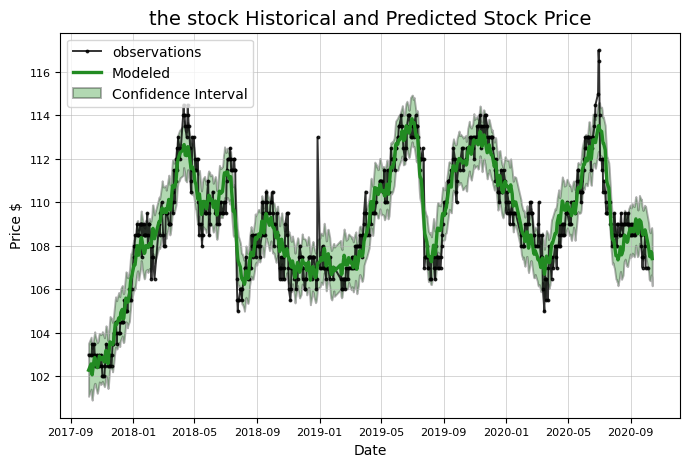

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:436: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



Predicted Price on 2020-10-13 00:00:00 = $9859543.28


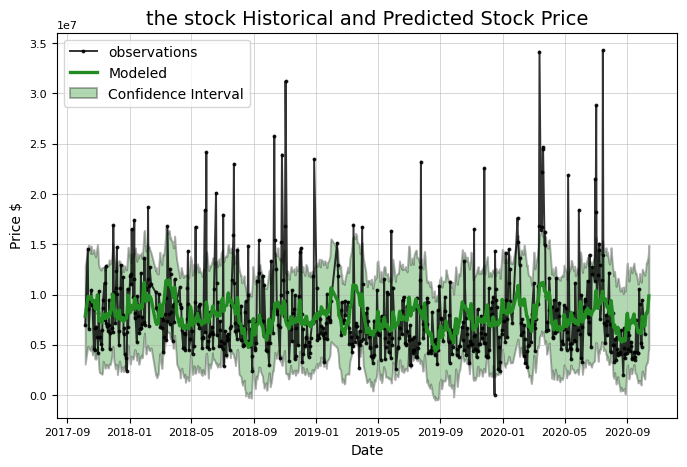

In [ ]:
model, model_data = tsmc.create_prophet_model(days=8)
model_volume, model_volume_data = tsmc_volume.create_prophet_model(days=8)


Predicted Increase: 

        Date    estimate    change       upper       lower
6 2020-10-11  107.738645  0.239248  108.862109  106.639605

Predicted Decrease: 

        Date    estimate    change       upper       lower
1 2020-10-06  107.911494 -0.146408  109.034514  106.749319
2 2020-10-07  107.692312 -0.219182  108.806876  106.564245
3 2020-10-08  107.519064 -0.173248  108.670645  106.401454
4 2020-10-09  107.499397 -0.019667  108.550768  106.318426
7 2020-10-12  107.687871 -0.050774  108.858731  106.598289
8 2020-10-13  107.416937 -0.270934  108.589347  106.270717


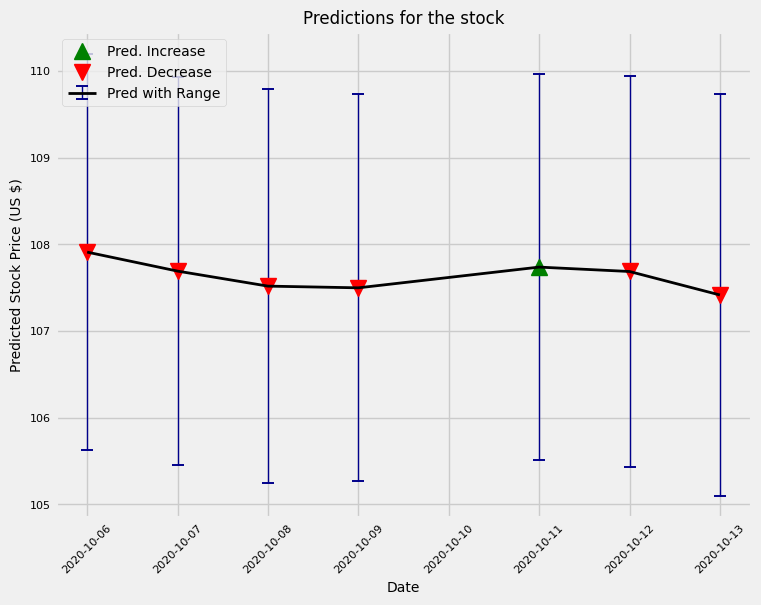


Predicted Increase: 

        Date      estimate         change         upper         lower
1 2020-10-06  7.318187e+06  457547.528644  1.226485e+07  2.345575e+06
2 2020-10-07  7.881857e+06  563670.177473  1.279376e+07  2.973946e+06
3 2020-10-08  8.169209e+06  287352.333950  1.306121e+07  2.673330e+06
6 2020-10-11  8.569397e+06  402235.266082  1.358436e+07  4.028472e+06
7 2020-10-12  9.241953e+06  672555.507093  1.436592e+07  4.040191e+06
8 2020-10-13  9.859543e+06  617590.507364  1.459502e+07  4.536301e+06

Predicted Decrease: 

        Date      estimate       change         upper         lower
4 2020-10-09  8.167162e+06 -2047.273694  1.359077e+07  3.198551e+06


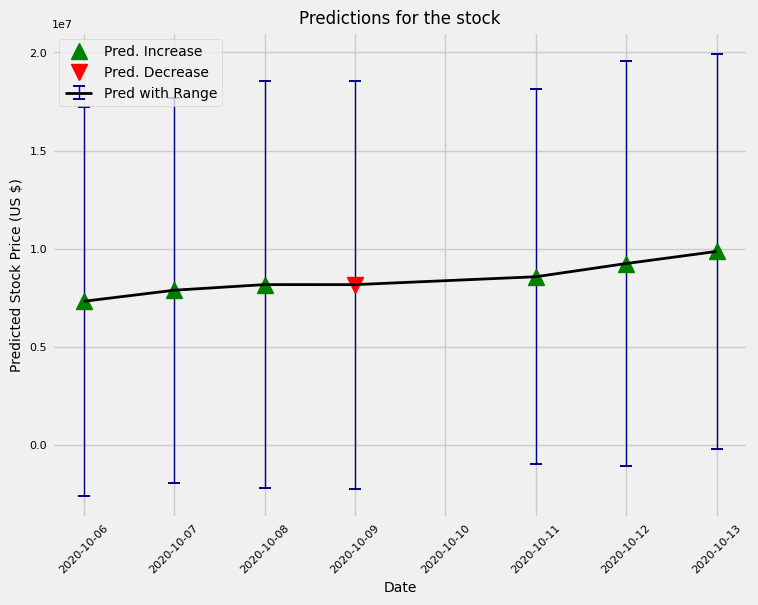

In [ ]:
increase, decrease = tsmc.predict_future(days=8)
increase_volume, decrease_volume = tsmc_volume.predict_future(days=8)

In [ ]:
# 將計算出來的漲和跌預測dataframe融合成一個dataframe
predict = pd.concat([increase, decrease])
predict

,Date,trend,lower,upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,estimate,change,direction
6,2020-10-11,106.913580,106.639605,108.862109,106.913580,106.913580,0.825065,0.825065,0.825065,0.287648,0.287648,0.287648,0.537417,0.537417,0.537417,0.0,0.0,0.0,107.738645,0.239248,1
1,2020-10-06,106.984762,106.749319,109.034514,106.984762,106.984762,0.926732,0.926732,0.926732,0.026643,0.026643,0.026643,0.900088,0.900088,0.900088,0.0,0.0,0.0,107.911494,-0.146408,0
2,2020-10-07,106.970526,106.564245,108.806876,106.970526,106.970526,0.721786,0.721786,0.721786,-0.101283,-0.101283,-0.101283,0.823069,0.823069,0.823069,0.0,0.0,0.0,107.692312,-0.219182,0
3,2020-10-08,106.956289,106.401454,108.670645,106.956289,106.956289,0.562775,0.562775,0.562775,-0.185049,-0.185049,-0.185049,0.747824,0.747824,0.747824,0.0,0.0,0.0,107.519064,-0.173248,0
4,2020-10-09,106.942053,106.318426,108.550768,106.942053,106.942053,0.557344,0.557344,0.557344,-0.117535,-0.117535,-0.117535,0.674879,0.674879,0.674879,0.0,0.0,0.0,107.499397,-0.019667,0
7,2020-10-12,106.899344,106.598289,108.858731,106.899344,106.899344,0.788528,0.788528,0.788528,0.315175,0.315175,0.315175,0.473353,0.473353,0.473353,0.0,0.0,0.0,107.687871,-0.050774,0
8,2020-10-13,106.885107,106.270717,108.589347,106.885107,106.885107,0.531830,0.531830,0.531830,0.119341,0.119341,0.119341,0.412489,0.412489,0.412489,0.0,0.0,0.0,107.416937,-0.270934,0


In [ ]:
# 將此dataframe按照index大小做排列(日期)
predict = predict.sort_index(axis=0)
predict

,Date,trend,lower,upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,estimate,change,direction
1,2020-10-06,106.984762,106.749319,109.034514,106.984762,106.984762,0.926732,0.926732,0.926732,0.026643,0.026643,0.026643,0.900088,0.900088,0.900088,0.0,0.0,0.0,107.911494,-0.146408,0
2,2020-10-07,106.970526,106.564245,108.806876,106.970526,106.970526,0.721786,0.721786,0.721786,-0.101283,-0.101283,-0.101283,0.823069,0.823069,0.823069,0.0,0.0,0.0,107.692312,-0.219182,0
3,2020-10-08,106.956289,106.401454,108.670645,106.956289,106.956289,0.562775,0.562775,0.562775,-0.185049,-0.185049,-0.185049,0.747824,0.747824,0.747824,0.0,0.0,0.0,107.519064,-0.173248,0
4,2020-10-09,106.942053,106.318426,108.550768,106.942053,106.942053,0.557344,0.557344,0.557344,-0.117535,-0.117535,-0.117535,0.674879,0.674879,0.674879,0.0,0.0,0.0,107.499397,-0.019667,0
6,2020-10-11,106.913580,106.639605,108.862109,106.913580,106.913580,0.825065,0.825065,0.825065,0.287648,0.287648,0.287648,0.537417,0.537417,0.537417,0.0,0.0,0.0,107.738645,0.239248,1
7,2020-10-12,106.899344,106.598289,108.858731,106.899344,106.899344,0.788528,0.788528,0.788528,0.315175,0.315175,0.315175,0.473353,0.473353,0.473353,0.0,0.0,0.0,107.687871,-0.050774,0
8,2020-10-13,106.885107,106.270717,108.589347,106.885107,106.885107,0.531830,0.531830,0.531830,0.119341,0.119341,0.119341,0.412489,0.412489,0.412489,0.0,0.0,0.0,107.416937,-0.270934,0


In [ ]:
# 將此dataframe的index更換為0~predict.shape[0]的序列
change_index = []
for i in range(predict.shape[0]):
    change_index.append(i)

predict.index = pd.Series(change_index)
predict

,Date,trend,lower,upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,estimate,change,direction
0,2020-10-06,106.984762,106.749319,109.034514,106.984762,106.984762,0.926732,0.926732,0.926732,0.026643,0.026643,0.026643,0.900088,0.900088,0.900088,0.0,0.0,0.0,107.911494,-0.146408,0
1,2020-10-07,106.970526,106.564245,108.806876,106.970526,106.970526,0.721786,0.721786,0.721786,-0.101283,-0.101283,-0.101283,0.823069,0.823069,0.823069,0.0,0.0,0.0,107.692312,-0.219182,0
2,2020-10-08,106.956289,106.401454,108.670645,106.956289,106.956289,0.562775,0.562775,0.562775,-0.185049,-0.185049,-0.185049,0.747824,0.747824,0.747824,0.0,0.0,0.0,107.519064,-0.173248,0
3,2020-10-09,106.942053,106.318426,108.550768,106.942053,106.942053,0.557344,0.557344,0.557344,-0.117535,-0.117535,-0.117535,0.674879,0.674879,0.674879,0.0,0.0,0.0,107.499397,-0.019667,0
4,2020-10-11,106.913580,106.639605,108.862109,106.913580,106.913580,0.825065,0.825065,0.825065,0.287648,0.287648,0.287648,0.537417,0.537417,0.537417,0.0,0.0,0.0,107.738645,0.239248,1
5,2020-10-12,106.899344,106.598289,108.858731,106.899344,106.899344,0.788528,0.788528,0.788528,0.315175,0.315175,0.315175,0.473353,0.473353,0.473353,0.0,0.0,0.0,107.687871,-0.050774,0
6,2020-10-13,106.885107,106.270717,108.589347,106.885107,106.885107,0.531830,0.531830,0.531830,0.119341,0.119341,0.119341,0.412489,0.412489,0.412489,0.0,0.0,0.0,107.416937,-0.270934,0


In [ ]:
# 將計算出來volume的漲和跌預測dataframe融合成一個dataframe
predict_volume = pd.concat([increase_volume, decrease_volume])
predict_volume

,Date,trend,lower,upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,estimate,change,direction
1,2020-10-06,8.298348e+06,2.345575e+06,1.226485e+07,8.298348e+06,8.298348e+06,-9.801616e+05,-9.801616e+05,-9.801616e+05,-444834.060034,-444834.060034,-444834.060034,-535327.502996,-535327.502996,-535327.502996,0.0,0.0,0.0,7.318187e+06,457547.528644,1
2,2020-10-07,8.300244e+06,2.973946e+06,1.279376e+07,8.300244e+06,8.300244e+06,-4.183873e+05,-4.183873e+05,-4.183873e+05,-84369.632698,-84369.632698,-84369.632698,-334017.695171,-334017.695171,-334017.695171,0.0,0.0,0.0,7.881857e+06,563670.177473,1
3,2020-10-08,8.302140e+06,2.673330e+06,1.306121e+07,8.302140e+06,8.302140e+06,-1.329309e+05,-1.329309e+05,-1.329309e+05,-4435.597011,-4435.597011,-4435.597011,-128495.339220,-128495.339220,-128495.339220,0.0,0.0,0.0,8.169209e+06,287352.333950,1
6,2020-10-11,8.307828e+06,4.028472e+06,1.358436e+07,8.307828e+06,8.307828e+06,2.615692e+05,2.615692e+05,2.615692e+05,-212039.744124,-212039.744124,-212039.744124,473608.973345,473608.973345,473608.973345,0.0,0.0,0.0,8.569397e+06,402235.266082,1
7,2020-10-12,8.309724e+06,4.040191e+06,1.436592e+07,8.309724e+06,8.309724e+06,9.322288e+05,9.322288e+05,9.322288e+05,275903.253534,275903.253534,275903.253534,656325.540468,656325.540468,656325.540468,0.0,0.0,0.0,9.241953e+06,672555.507093,1
8,2020-10-13,8.311620e+06,4.536301e+06,1.459502e+07,8.311620e+06,8.311620e+06,1.547923e+06,1.547923e+06,1.547923e+06,724074.736778,724074.736778,724074.736778,823848.622276,823848.622276,823848.622276,0.0,0.0,0.0,9.859543e+06,617590.507364,1
4,2020-10-09,8.304036e+06,3.198551e+06,1.359077e+07,8.304036e+06,8.304036e+06,-1.368742e+05,-1.368742e+05,-1.368742e+05,-214161.136794,-214161.136794,-214161.136794,77286.984557,77286.984557,77286.984557,0.0,0.0,0.0,8.167162e+06,-2047.273694,0


In [ ]:
# 將此dataframe按照index大小做排列(日期)
predict_volume = predict_volume.sort_index(axis=0)
predict_volume

,Date,trend,lower,upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,estimate,change,direction
1,2020-10-06,8.298348e+06,2.345575e+06,1.226485e+07,8.298348e+06,8.298348e+06,-9.801616e+05,-9.801616e+05,-9.801616e+05,-444834.060034,-444834.060034,-444834.060034,-535327.502996,-535327.502996,-535327.502996,0.0,0.0,0.0,7.318187e+06,457547.528644,1
2,2020-10-07,8.300244e+06,2.973946e+06,1.279376e+07,8.300244e+06,8.300244e+06,-4.183873e+05,-4.183873e+05,-4.183873e+05,-84369.632698,-84369.632698,-84369.632698,-334017.695171,-334017.695171,-334017.695171,0.0,0.0,0.0,7.881857e+06,563670.177473,1
3,2020-10-08,8.302140e+06,2.673330e+06,1.306121e+07,8.302140e+06,8.302140e+06,-1.329309e+05,-1.329309e+05,-1.329309e+05,-4435.597011,-4435.597011,-4435.597011,-128495.339220,-128495.339220,-128495.339220,0.0,0.0,0.0,8.169209e+06,287352.333950,1
4,2020-10-09,8.304036e+06,3.198551e+06,1.359077e+07,8.304036e+06,8.304036e+06,-1.368742e+05,-1.368742e+05,-1.368742e+05,-214161.136794,-214161.136794,-214161.136794,77286.984557,77286.984557,77286.984557,0.0,0.0,0.0,8.167162e+06,-2047.273694,0
6,2020-10-11,8.307828e+06,4.028472e+06,1.358436e+07,8.307828e+06,8.307828e+06,2.615692e+05,2.615692e+05,2.615692e+05,-212039.744124,-212039.744124,-212039.744124,473608.973345,473608.973345,473608.973345,0.0,0.0,0.0,8.569397e+06,402235.266082,1
7,2020-10-12,8.309724e+06,4.040191e+06,1.436592e+07,8.309724e+06,8.309724e+06,9.322288e+05,9.322288e+05,9.322288e+05,275903.253534,275903.253534,275903.253534,656325.540468,656325.540468,656325.540468,0.0,0.0,0.0,9.241953e+06,672555.507093,1
8,2020-10-13,8.311620e+06,4.536301e+06,1.459502e+07,8.311620e+06,8.311620e+06,1.547923e+06,1.547923e+06,1.547923e+06,724074.736778,724074.736778,724074.736778,823848.622276,823848.622276,823848.622276,0.0,0.0,0.0,9.859543e+06,617590.507364,1


In [ ]:
# 將此dataframe的index更換為0~predict_volume.shape[0]的序列
change_index = []
for i in range(predict_volume.shape[0]):
    change_index.append(i)

predict_volume.index = pd.Series(change_index)
predict_volume

,Date,trend,lower,upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,estimate,change,direction
0,2020-10-06,8.298348e+06,2.345575e+06,1.226485e+07,8.298348e+06,8.298348e+06,-9.801616e+05,-9.801616e+05,-9.801616e+05,-444834.060034,-444834.060034,-444834.060034,-535327.502996,-535327.502996,-535327.502996,0.0,0.0,0.0,7.318187e+06,457547.528644,1
1,2020-10-07,8.300244e+06,2.973946e+06,1.279376e+07,8.300244e+06,8.300244e+06,-4.183873e+05,-4.183873e+05,-4.183873e+05,-84369.632698,-84369.632698,-84369.632698,-334017.695171,-334017.695171,-334017.695171,0.0,0.0,0.0,7.881857e+06,563670.177473,1
2,2020-10-08,8.302140e+06,2.673330e+06,1.306121e+07,8.302140e+06,8.302140e+06,-1.329309e+05,-1.329309e+05,-1.329309e+05,-4435.597011,-4435.597011,-4435.597011,-128495.339220,-128495.339220,-128495.339220,0.0,0.0,0.0,8.169209e+06,287352.333950,1
3,2020-10-09,8.304036e+06,3.198551e+06,1.359077e+07,8.304036e+06,8.304036e+06,-1.368742e+05,-1.368742e+05,-1.368742e+05,-214161.136794,-214161.136794,-214161.136794,77286.984557,77286.984557,77286.984557,0.0,0.0,0.0,8.167162e+06,-2047.273694,0
4,2020-10-11,8.307828e+06,4.028472e+06,1.358436e+07,8.307828e+06,8.307828e+06,2.615692e+05,2.615692e+05,2.615692e+05,-212039.744124,-212039.744124,-212039.744124,473608.973345,473608.973345,473608.973345,0.0,0.0,0.0,8.569397e+06,402235.266082,1
5,2020-10-12,8.309724e+06,4.040191e+06,1.436592e+07,8.309724e+06,8.309724e+06,9.322288e+05,9.322288e+05,9.322288e+05,275903.253534,275903.253534,275903.253534,656325.540468,656325.540468,656325.540468,0.0,0.0,0.0,9.241953e+06,672555.507093,1
6,2020-10-13,8.311620e+06,4.536301e+06,1.459502e+07,8.311620e+06,8.311620e+06,1.547923e+06,1.547923e+06,1.547923e+06,724074.736778,724074.736778,724074.736778,823848.622276,823848.622276,823848.622276,0.0,0.0,0.0,9.859543e+06,617590.507364,1


In [ ]:
# 將需要的資料抓取下來並新建一dataframe
# increase, decrease = 1, 0
open_price = predict["estimate"]
high_price = predict["upper"]
low_price = predict["lower"]
volume = predict_volume["estimate"]
close_price = []

for i,x in enumerate(predict["direction"]):
    if x == 0:
        close_price.append(predict["lower"][i])
    else:
        close_price.append(predict["upper"][i])

data = {'High':high_price,
		'Low':low_price,
		'Open':open_price,
		'Close':close_price,
		'Volume':volume,
		'Adj Close':0}

predict_plot = pd.DataFrame(data)
predict_plot.index = pd.to_datetime(predict["Date"])
predict_plot

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-10-06,109.034514,106.749319,107.911494,106.749319,7.318187e+06,0
2020-10-07,108.806876,106.564245,107.692312,106.564245,7.881857e+06,0
2020-10-08,108.670645,106.401454,107.519064,106.401454,8.169209e+06,0
2020-10-09,108.550768,106.318426,107.499397,106.318426,8.167162e+06,0
2020-10-11,108.862109,106.639605,107.738645,108.862109,8.569397e+06,0
2020-10-12,108.858731,106.598289,107.687871,106.598289,9.241953e+06,0
2020-10-13,108.589347,106.270717,107.416937,106.270717,9.859543e+06,0


In [ ]:
#把與預測資料同一天的都刪除
dropTimeZone = []
dropTimestart = datetime.datetime(2020,1,1)
dropTimeend = predict_plot.index[0].date()

for z in df.index:
    if z >= dropTimeend or z < dropTimestart:
        dropTimeZone.append(z)

df = df.drop(index = dropTimeZone)

#為了要將預測及真實資料畫在同一張圖,因此需要把預測資料8/27前面日期的資料用真實資料補齊
predict_plot_up = df
predict_plot_up

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,110.5,109.5,110.5,109.5,8125141.0,105.527924
2020-01-03,110.5,109.5,110.0,110.5,7416848.0,106.491646
2020-01-06,110.5,110.0,110.5,110.0,5303895.0,106.009789
2020-01-07,110.0,108.5,110.0,109.5,14171476.0,105.527924
2020-01-08,110.0,109.0,109.5,109.0,9437253.0,105.046059
...,...,...,...,...,...,...
2020-09-25,107.5,106.5,107.5,107.5,9077801.0,107.500000
2020-09-28,108.0,107.0,107.5,108.0,5209260.0,108.000000
2020-09-29,108.5,107.5,108.0,108.5,4797564.0,108.500000


In [ ]:
#合併真實資料與預測資料
df_predict = pd.concat([predict_plot_up, predict_plot])
df_predict

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,110.500000,109.500000,110.500000,109.500000,8.125141e+06,105.527924
2020-01-03,110.500000,109.500000,110.000000,110.500000,7.416848e+06,106.491646
2020-01-06,110.500000,110.000000,110.500000,110.000000,5.303895e+06,106.009789
2020-01-07,110.000000,108.500000,110.000000,109.500000,1.417148e+07,105.527924
2020-01-08,110.000000,109.000000,109.500000,109.000000,9.437253e+06,105.046059
...,...,...,...,...,...,...
2020-10-08,108.670645,106.401454,107.519064,106.401454,8.169209e+06,0.000000
2020-10-09,108.550768,106.318426,107.499397,106.318426,8.167162e+06,0.000000
2020-10-11,108.862109,106.639605,107.738645,108.862109,8.569397e+06,0.000000


In [ ]:
# df_predict.to_csv('example.csv', index = True)

In [ ]:
# type(df_predict['Open'])

pandas.core.series.Series

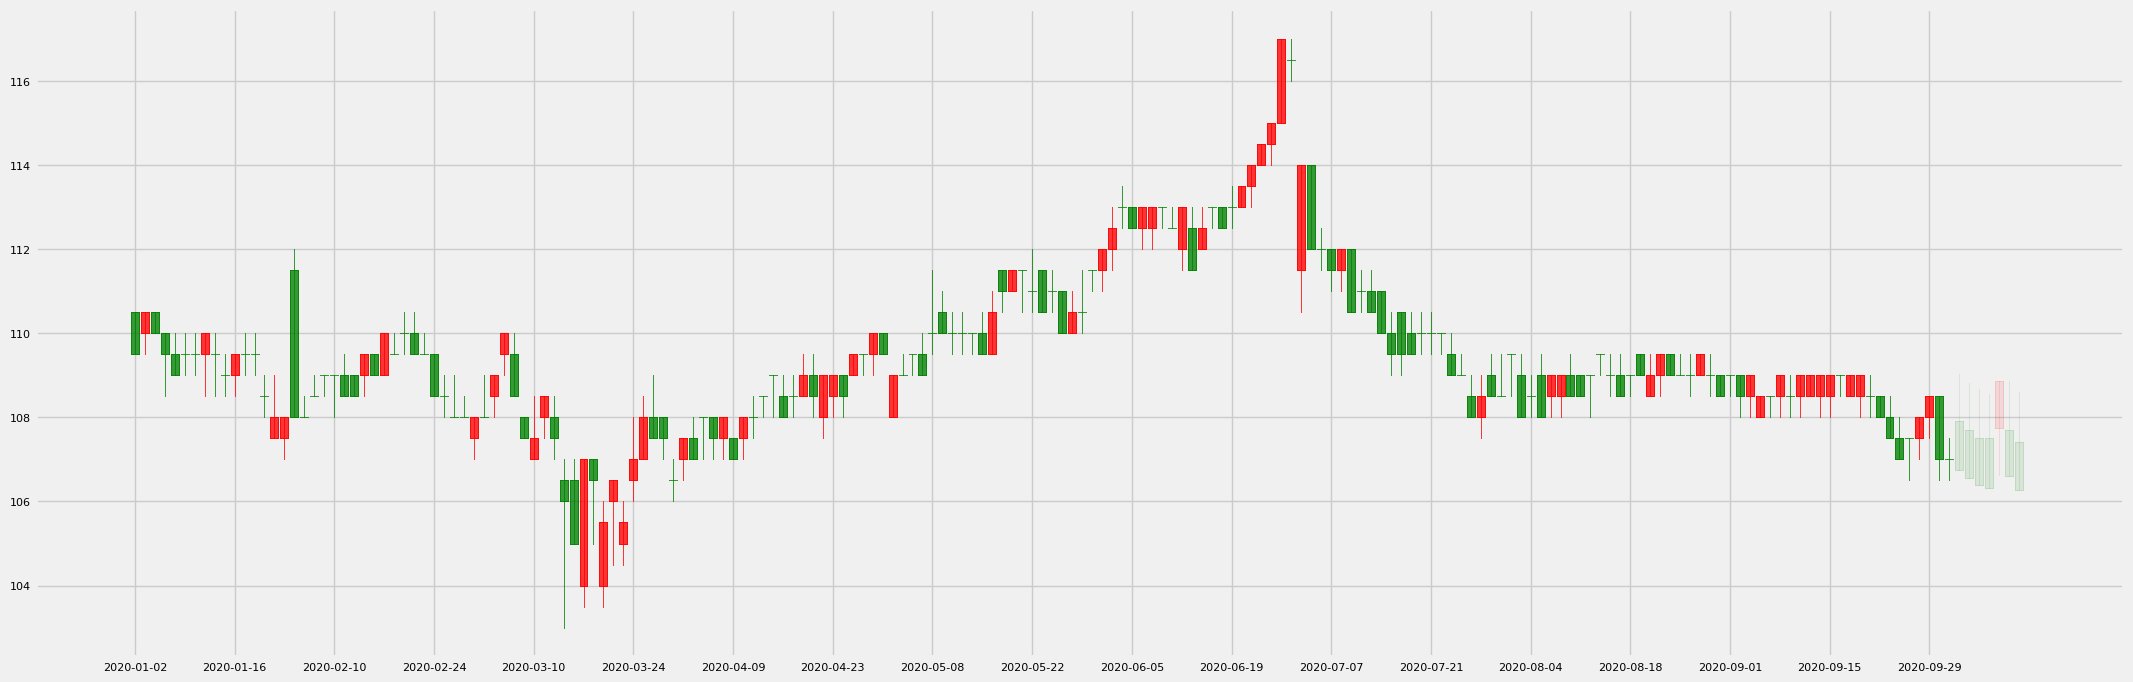

In [ ]:
try:
    df.index = df.index.format(formatter=lambda x: x.strftime('%Y-%m-%d')) 
    df_predict.index = df_predict.index.format(formatter=lambda x: x.strftime('%Y-%m-%d')) 

except:
    pass

finally:
    fig = plt.figure(figsize=(24, 8))

    ax = fig.add_subplot(1, 1, 1)
    ax.set_xticks(range(0, len(df_predict.index), 10))
    ax.set_xticklabels(df_predict.index[::10])

    #為了兩種不同顏色因此前半段使用drop過後的df
    mpf.candlestick2_ochl(ax, df['Open'], df['Close'], df['High'],
                        df['Low'], width=0.8, colorup='r', colordown='g', alpha=0.75)

    #為了兩種不同顏色因此後半段使用融合過後的df_predict
    mpf.candlestick2_ochl(ax, df_predict['Open'], df_predict['Close'], df_predict['High'],
                        df_predict['Low'], width=0.8, colorup='r', colordown='g', alpha=0.1)
    plt.show(1)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 26085 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 22343 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 32218 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 26085 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 22343 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 32218 missing from current font.



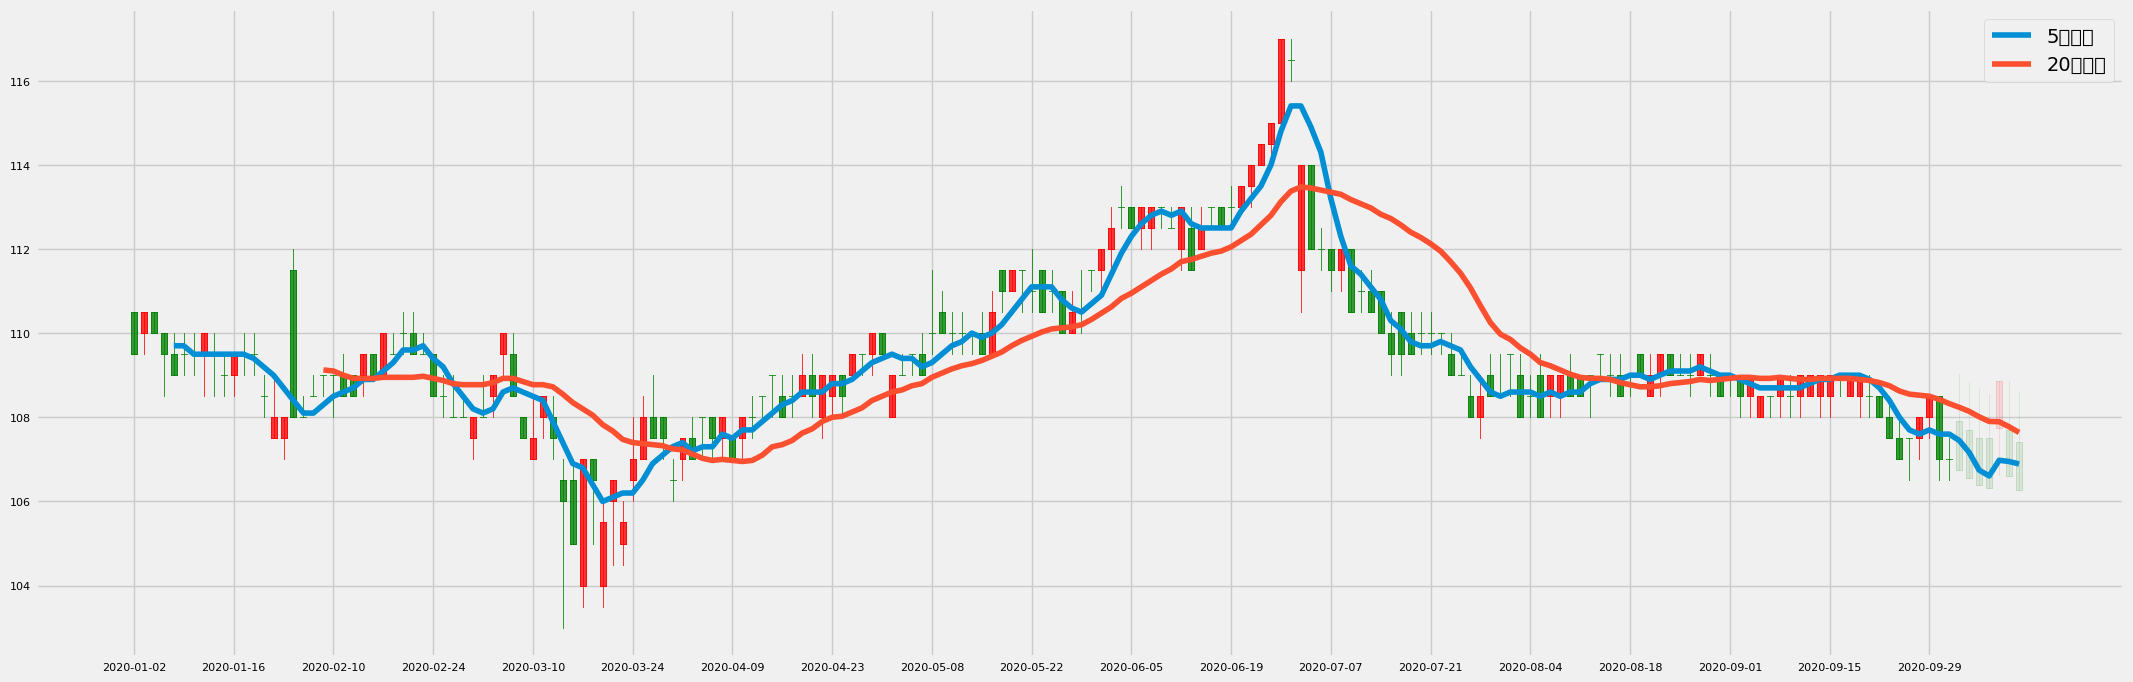

In [ ]:
#加上均線,加上5日均線和20日均線

sma_5 = talib.SMA(np.array(df_predict['Close']), 5)
sma_20 = talib.SMA(np.array(df_predict['Close']), 20)

fig = plt.figure(figsize=(24, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks(range(0, len(df_predict.index), 10))
ax.set_xticklabels(df_predict.index[::10])

mpf.candlestick2_ochl(ax, df['Open'], df['Close'], df['High'],
                      df['Low'], width=0.6, colorup='r', colordown='g', alpha=0.75)

mpf.candlestick2_ochl(ax, df_predict['Open'], df_predict['Close'], df_predict['High'],
                      df_predict['Low'], width=0.6, colorup='r', colordown='g', alpha=0.1)
# plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] 
ax.plot(sma_5, label="5日均線")
ax.plot(sma_20, label="20日均線")
ax.legend()
plt.show(1)

In [ ]:
sma_5

array([         nan,          nan,          nan,          nan,
       109.7       , 109.7       , 109.5       , 109.5       ,
       109.5       , 109.5       , 109.5       , 109.5       ,
       109.4       , 109.2       , 109.        , 108.7       ,
       108.4       , 108.1       , 108.1       , 108.3       ,
       108.5       , 108.6       , 108.7       , 108.9       ,
       108.9       , 109.1       , 109.3       , 109.6       ,
       109.6       , 109.7       , 109.4       , 109.2       ,
       108.8       , 108.5       , 108.2       , 108.1       ,
       108.2       , 108.6       , 108.7       , 108.6       ,
       108.5       , 108.4       , 107.9       , 107.4       ,
       106.9       , 106.8       , 106.4       , 106.        ,
       106.1       , 106.2       , 106.2       , 106.5       ,
       106.9       , 107.1       , 107.3       , 107.4       ,
       107.2       , 107.3       , 107.3       , 107.6       ,
       107.5       , 107.7       , 107.7       , 107.9 

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 26085 missing from current font.

/usr

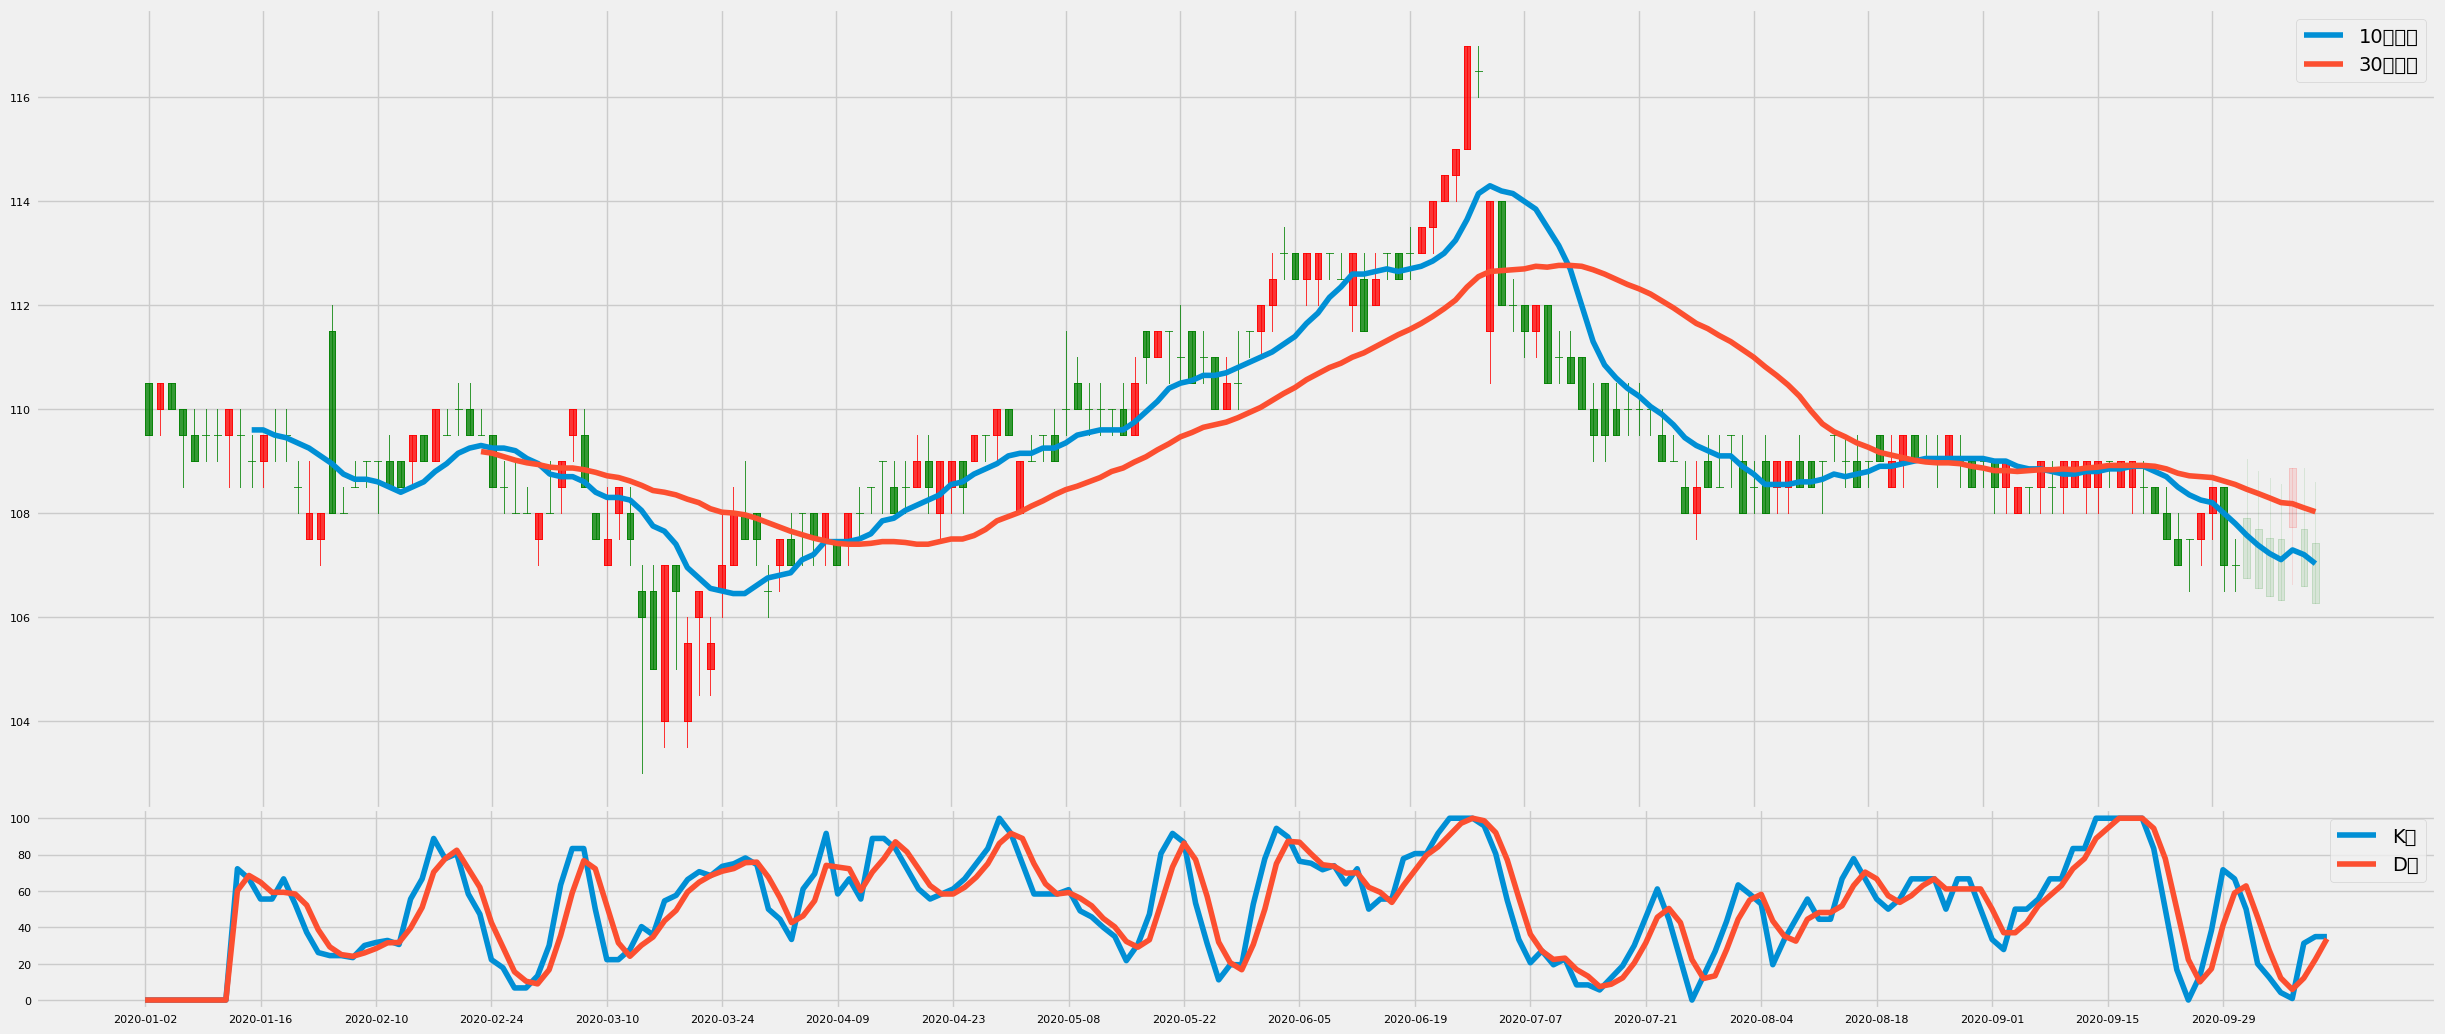

In [ ]:
#加上KD指標
sma_10 = talib.SMA(np.array(df_predict['Close']), 10)
sma_30 = talib.SMA(np.array(df_predict['Close']), 30)
df_predict['k'], df_predict['d'] = talib.STOCH(df_predict['High'], df_predict['Low'], df_predict['Close'])
df_predict['k'].fillna(value=0, inplace=True)
df_predict['d'].fillna(value=0, inplace=True)

fig = plt.figure(figsize=(24, 20))
ax = fig.add_axes([0,0.3,1,0.4])
ax2 = fig.add_axes([0,0.2,1,0.1])

ax.set_xticks(range(0, len(df_predict.index), 10))
ax.set_xticklabels(df_predict.index[::10])
mpf.candlestick2_ochl(ax, df['Open'], df['Close'], df['High'],
                      df['Low'], width=0.6, colorup='r', colordown='g', alpha=0.75)

mpf.candlestick2_ochl(ax, df_predict['Open'], df_predict['Close'], df_predict['High'],
                      df_predict['Low'], width=0.6, colorup='r', colordown='g', alpha=0.1)
plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] 
ax.plot(sma_10, label='10日均線')
ax.plot(sma_30, label='30日均線')

ax2.plot(df_predict['k'], label='K值')
ax2.plot(df_predict['d'], label='D值')
ax2.set_xticks(range(0, len(df_predict.index), 10))
ax2.set_xticklabels(df_predict.index[::10])


ax.legend();
ax2.legend();
plt.show(1)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 26085 missing from current font.

/usr

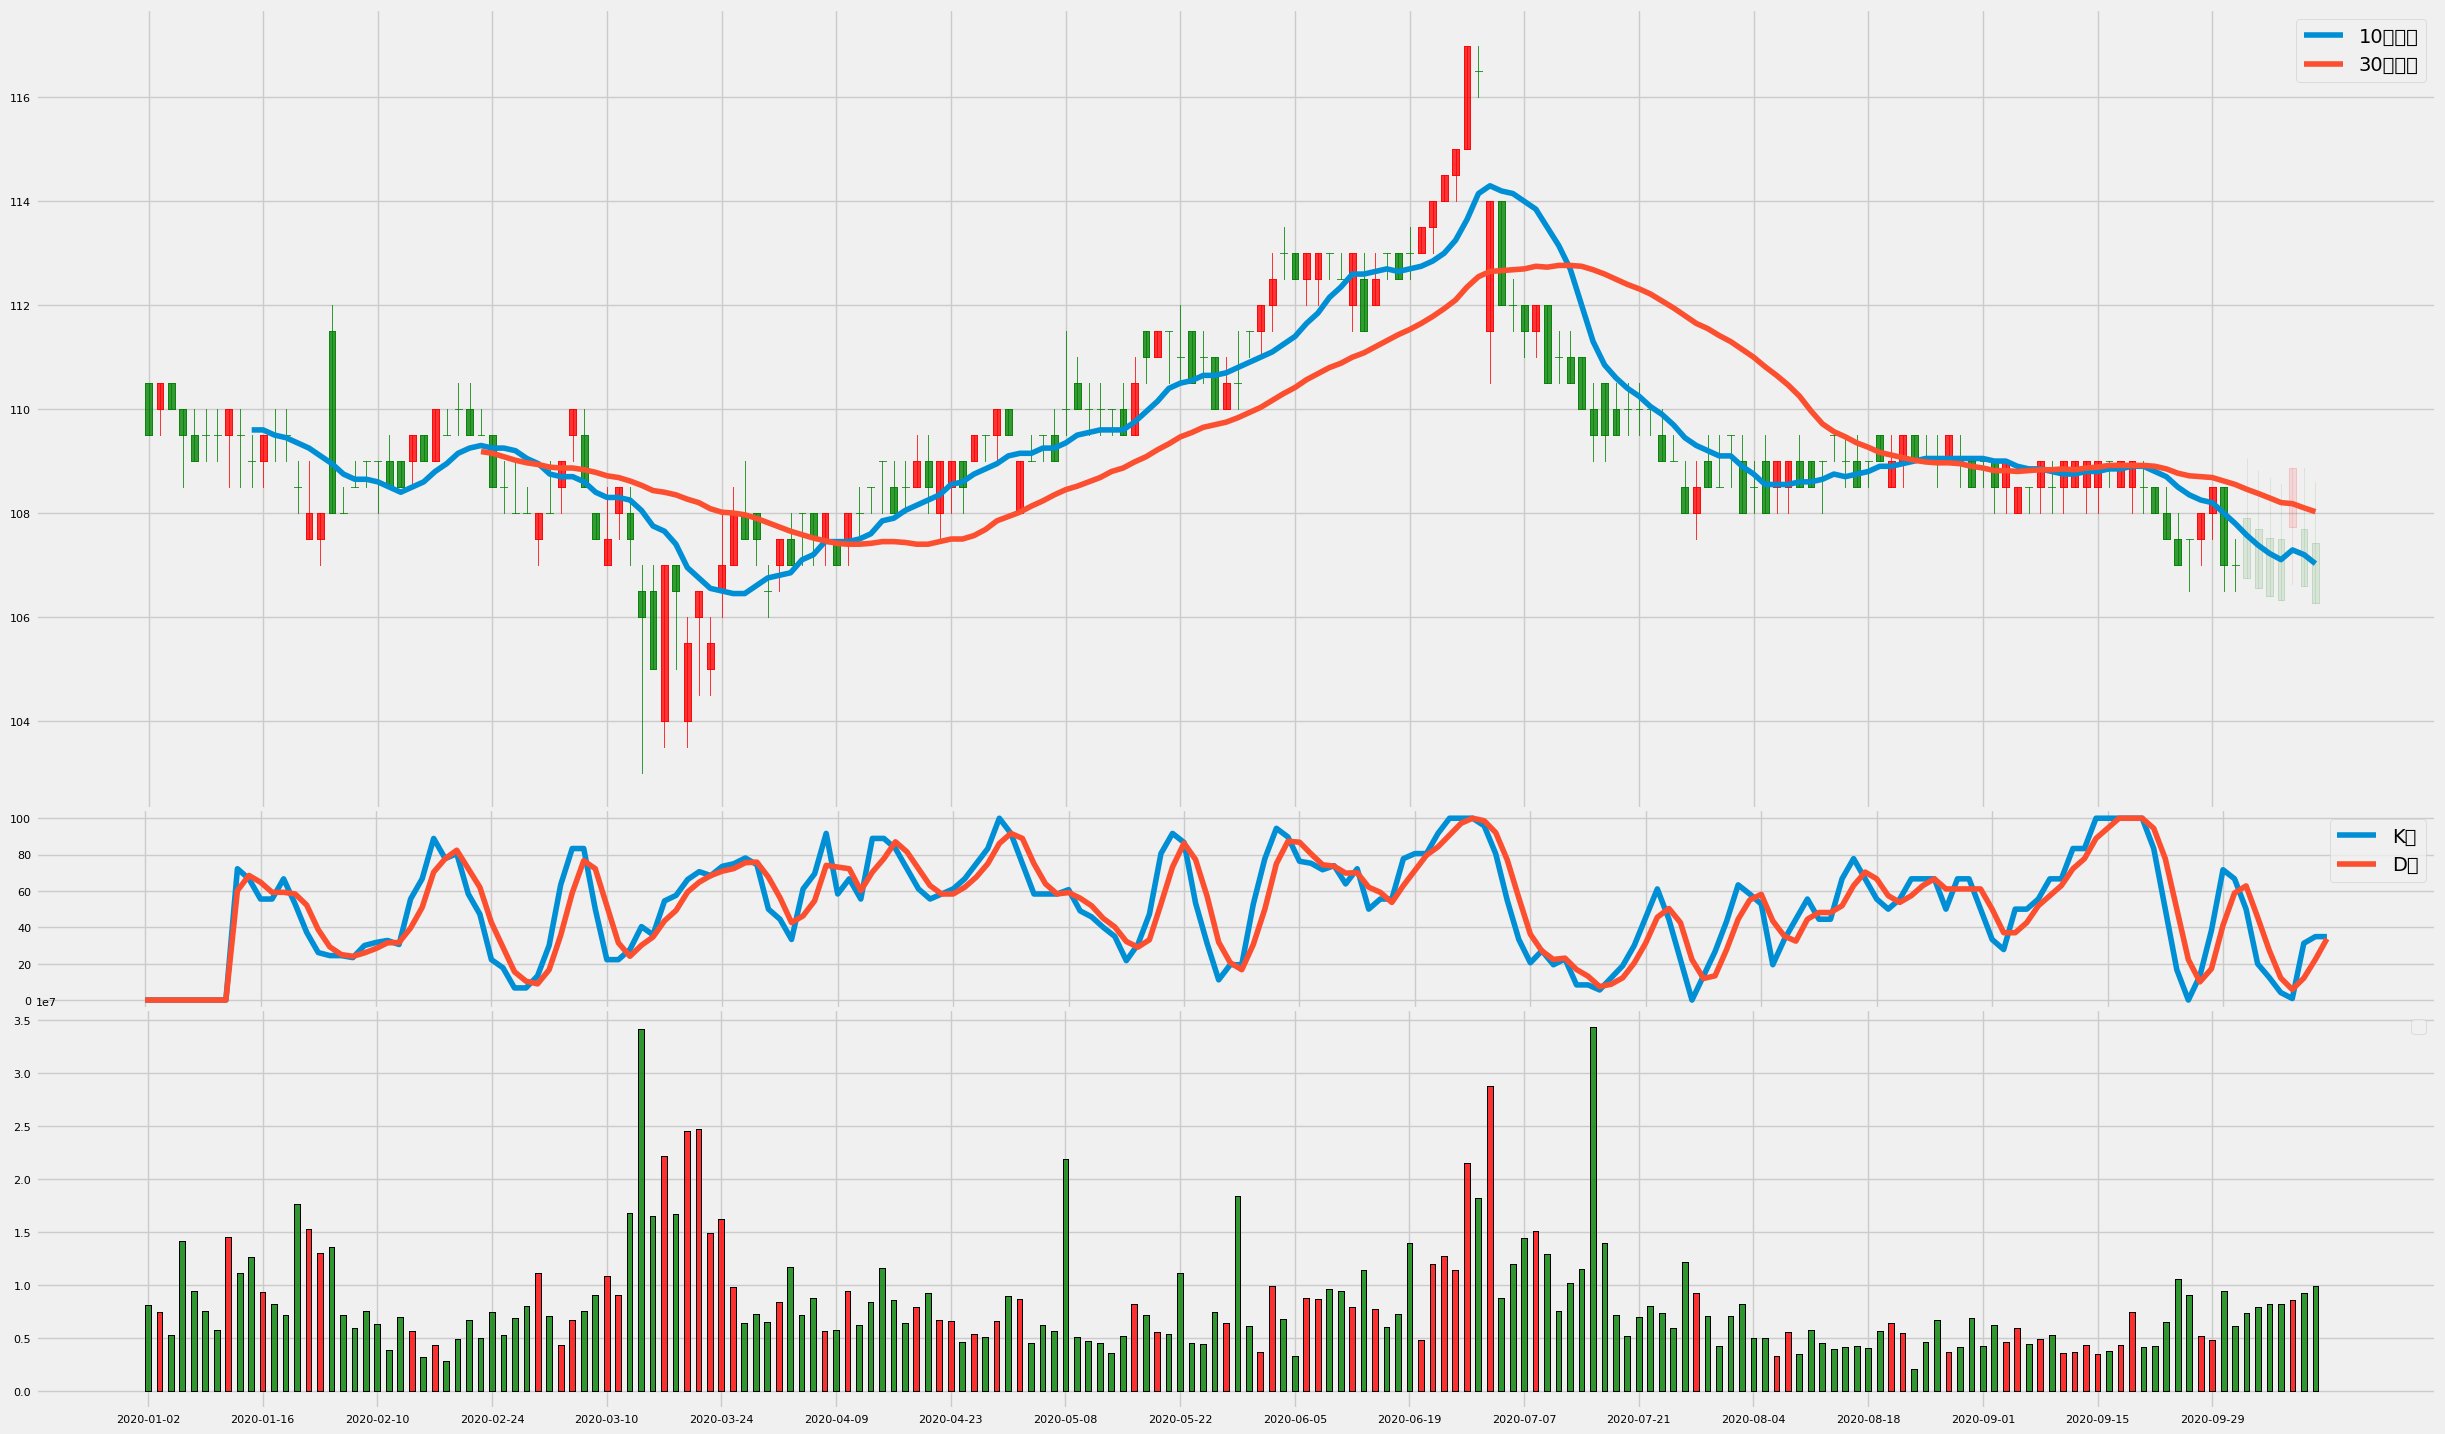

In [ ]:
#加上量指標
sma_10 = talib.SMA(np.array(df_predict['Close']), 10)
sma_30 = talib.SMA(np.array(df_predict['Close']), 30)
df_predict['k'], df_predict['d'] = talib.STOCH(df_predict['High'], df_predict['Low'], df_predict['Close'])
df_predict['k'].fillna(value=0, inplace=True)
df_predict['d'].fillna(value=0, inplace=True)

fig = plt.figure(figsize=(24, 20))
ax = fig.add_axes([0,0.3,1,0.4])
ax2 = fig.add_axes([0,0.2,1,0.1])
ax3 = fig.add_axes([0,0,1,0.2])

ax.set_xticks(range(0, len(df_predict.index), 10))
ax.set_xticklabels(df_predict.index[::10])
mpf.candlestick2_ochl(ax, df['Open'], df['Close'], df['High'],
                      df['Low'], width=0.6, colorup='r', colordown='g', alpha=0.75)

mpf.candlestick2_ochl(ax, df_predict['Open'], df_predict['Close'], df_predict['High'],
                      df_predict['Low'], width=0.6, colorup='r', colordown='g', alpha=0.1)

# 這裡只有把Yahoo從2002/01/01到最新的資料去畫量,所以下面的圖的x軸時間點會不一樣
# 因為KD/MA都是有加上預測圖,但是Yahoo的量不可能會有未來的量所以合起來下方時間軸會不一樣
mpf.volume_overlay(ax3, df_predict['Open'], df_predict['Close'], df_predict['Volume'], colorup='r', colordown='g', width=0.5, alpha=0.8)


plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] 
ax.plot(sma_10, label='10日均線')
ax.plot(sma_30, label='30日均線')

ax2.plot(df_predict['k'], label='K值')
ax2.plot(df_predict['d'], label='D值')
ax2.set_xticks(range(0, len(df_predict.index), 10))
ax2.set_xticklabels(df_predict.index[::10])
ax3.set_xticks(range(0, len(df.index), 10))
ax3.set_xticklabels(df.index[::10])


ax.legend();
ax2.legend();
ax3.legend();
plt.show(1)